When it comes to consuming real-time content, Twitter is the place to be; Be it sending out 'Tweets' real-time, or discovering latest online 'Trends' anywhere, or ability to begin a 'conversation' with anyone, Twitter does it all. In fact, Twitter Management wrote this in their [letter to shareholders][1] last year. 
[1]: http://files.shareholder.com/downloads/AMDA-2F526X/106725176x0x874459/8A4D1A1D-D184-4AFE-9AC1-F880C5EA06F1/Q415_Shareholder_Letter.pdf

> _We’re focused now on what Twitter does best: live. Twitter is live: live commentary, live connections, live conversations. Whether it’s breaking news, entertainment, sports, or everyday topics, hearing about and watching a live event unfold is the fastest way to understand the power of Twitter._ 

> _Twitter has always been considered a “second screen” for what’s happening in the world and we believe we can become the first screen for everything that’s happening now. And by doing so, we believe we can build the planet’s largest daily connected audience. A connected audience is one that watches together, and can talk with one another in real-time. It’s what Twitter has provided for close to 10 years, and it’s what we will continue to drive in the future_

Embedded in a Twitter User's Social-graph* is a wealth of information on User's likes and interests. Unlike Facebook or LinkedIn, the magic of Twitter is in its 'Follow' structure - where any can follow any without they knowing each other. This directed social-graph, when methodologically summarized, can reveal interesting information on the most influential/central friends in the network and also help personalize/enrich one's Twitter experience by unearthing implicit-clusters in the network.

_*Social-graph: [User, 1st degree Connections, and the links between]_

In this notebook, we'll look into these: 
1. Extract the ego-network of 'self' using Twitter API 
+ Identify the influential nodes using 'Page Rank' formulation 
+ Identify implicit clusters formed
+ Recommend new friends to follow on the basis of cluster of interest 

Note: This study is limited to  Ego network: the focal node ("ego": here the self-node) and the nodes to whom ego is directly connected to ("alters") plus the ties, if any, among the alters. 

## 1. Extract social-graph strucutre using Twitter API 

In [1]:
from collections import Counter, defaultdict
from datetime import datetime
from sklearn.decomposition import PCA

import csv
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd
import re
import seaborn as sns;  sns.set()
import time
import tweepy

% matplotlib inline
plt.rcParams['figure.figsize'] = (10,7)

import warnings
warnings.filterwarnings("ignore")
#print twitter.__path__  

import random
random.seed(1000)

UsageError: Line magic function `%` not found.


In [2]:
self_screen_name = 'RohanKuntoji'            # Self

# Keep appending data
fof_filename     = "edges.csv"          # 'Alters' and their Source->Sink Edges. 
cache_filename   = "cache.csv"          # local cache of (TwitterId, FullName, UserName)

# One-time-use files
binaryMap_filename = "binaryMap.csv"   # Directed Graph. Adjacencies as 0/1.RowFollowCol
cluster_filename   = "results.csv"

In [3]:
# Twitter auth. https://dev.twitter.com/oauth/overview/application-owner-access-tokens

# with open("Credentials.txt", "r") as f:
#     reader = csv.reader(f)
#     login_dict = {line[0]: line[1]                       
#                     for line in reader}        
consumer_key = '99mcVQZahMAqkGUbVDhQDmlMb'
consumer_secret = 'ubyuWD52HKUcEmaeJxdidS1jjb5w0PC26LJaI7SFhu4TLc78tC'
access_token_key = '555800349-7mrd67Jfk6mO4fuyaZ5UMlIsdC311zRLOfdi6A4s'
access_token_secret = '7YiLUbDeJOMSIWQKiOP1kCsk0lKBfcvEd5ov4SP6MHIAx'


auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token_key, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [4]:
api.verify_credentials()

User(_api=<tweepy.api.API object at 0x1031afd68>, _json={'id': 555800349, 'id_str': '555800349', 'name': 'Rohan Kuntoji', 'screen_name': 'RohanKuntoji', 'location': 'Mysore, India', 'description': 'Machine Learning Engineer', 'url': 'https://t.co/JMvPA6YN6A', 'entities': {'url': {'urls': [{'url': 'https://t.co/JMvPA6YN6A', 'expanded_url': 'https://medium.com/@rohan.kuntoji', 'display_url': 'medium.com/@rohan.kuntoji', 'indices': [0, 23]}]}, 'description': {'urls': []}}, 'protected': False, 'followers_count': 34, 'friends_count': 71, 'listed_count': 0, 'created_at': 'Tue Apr 17 06:01:37 +0000 2012', 'favourites_count': 163, 'utc_offset': None, 'time_zone': None, 'geo_enabled': False, 'verified': False, 'statuses_count': 26, 'lang': None, 'status': {'created_at': 'Thu Dec 27 07:47:29 +0000 2018', 'id': 1078195649278033921, 'id_str': '1078195649278033921', 'text': 'The growing demand for the need of accountability and explainability with the AI systems, a hot talking point on a… https://t

In [5]:
api.rate_limit_status()

{'rate_limit_context': {'access_token': '555800349-7mrd67Jfk6mO4fuyaZ5UMlIsdC311zRLOfdi6A4s'},
 'resources': {'lists': {'/lists/list': {'limit': 15,
    'remaining': 15,
    'reset': 1570098609},
   '/lists/memberships': {'limit': 75, 'remaining': 75, 'reset': 1570098609},
   '/lists/subscribers/show': {'limit': 15,
    'remaining': 15,
    'reset': 1570098609},
   '/lists/members': {'limit': 900, 'remaining': 900, 'reset': 1570098609},
   '/lists/subscriptions': {'limit': 15, 'remaining': 15, 'reset': 1570098609},
   '/lists/show': {'limit': 75, 'remaining': 75, 'reset': 1570098609},
   '/lists/ownerships': {'limit': 15, 'remaining': 15, 'reset': 1570098609},
   '/lists/subscribers': {'limit': 180, 'remaining': 180, 'reset': 1570098609},
   '/lists/members/show': {'limit': 15, 'remaining': 15, 'reset': 1570098609},
   '/lists/statuses': {'limit': 900, 'remaining': 900, 'reset': 1570098609}},
  'application': {'/application/rate_limit_status': {'limit': 180,
    'remaining': 179,
    '

In [21]:
len(api.followers_ids(self_screen_name))

34

In [ ]:
api.followers_ids(scre)

In [6]:
print(tweepy.__path__)

['/Users/kuntojirohan/MCG/Twitter/twitter_graph/py36/lib/python3.6/site-packages/tweepy']


In [7]:
# 'Self' and Friends of Self

self_node    =  api.get_user(screen_name = self_screen_name)    
self_node_id =  self_node.id_str                      # Twitter Id of Self
print(self_node_id)

followers_of_self = api.followers_ids(user_id = self_node_id, 
                                   screen_name = self_screen_name , 
                                   stringify_ids = True)
index = [self_node_id] + followers_of_self
print(index)

555800349
['555800349', '368370629', '936278616723283969', '1083271068310167552', '1077262370265882624', '1041354301489143809', '3273665052', '550863197', '711538784773349376', '991172011383803905', '4656819318', '288100306', '973949310193762305', '775302652427014145', '2485794074', '214442052', '944427851280826368', '1060849038', '931879192714657793', '2892720997', '872434564580294657', '1397433151', '2995400325', '471745066', '808939724186546176', '802401256668962816', '2987872843', '552816252', '2817090294', '2770277582', '293318078', '2746233492', '2714911410', '2708920093', '112417329']


In [8]:
len(index)

35

In [9]:
# GetFriendIDs() API call is rate-limited at 15 req / 15 min 
# https://dev.twitter.com/rest/public/rate-limiting

# For each of the list of nodes, fetch the list of nodes it follows, append to file

def update_FoF_File(fileName, to_fetch_list):
    
    with open(fileName, 'a') as f:
        apiReqCount = 0
        
        for node in to_fetch_list:
            friends_of_node = api.followers_ids(user_id = node,  stringify_ids = True) 
            row = ','.join([str(i) for i in [node] +  friends_of_node ]) + "\n"
            f.write(row) 
            
            apiReqCount += 1
            
            if (apiReqCount == 15): 
                apiReqCount = 0
                
                print("Off to Sleep :)")
                time.sleep(15*60 + 5)  

In [10]:
# parse FoF file and return list of nodes, for whom source->sink Edges are already there.

def getFinishList(fileName):
        
    if not os.path.isfile(fileName):
        return [] 
    with open(fileName, 'r') as f:
        return [ row.strip().split(',')[0] for row in f ]  # 1st entry is a user

In [11]:
# Ego-network as adjacency-matrix
# Parses FoF file in order of index, create list of adjacencies as 0 | 1
# Writes to File. Adjacency-matrix in Row_follows_Column format

def updateBinaryMapFile(fof_filename, binaryMap_filename, index):
    
    with open(fof_filename, "r") as f:
        stripped_f = (line.replace('\r', '') for line in f)
        reader = csv.reader(stripped_f)
        fof_dict = {line[0]: line[1:] for line in reader 
                    if line[0] in index}   # dict of node:his_followers
        if self_node_id not in fof_dict:
            fof_dict[self_node_id] = index[1:]             # dict of Self
    
    bool_list = []
    
    for user in index:
        user_followers = set( fof_dict[user] )  
        bool_row = [item in user_followers for item in index]  # for each, fill T/F 
        bool_list.append(bool_row)
    
    int_nparray = np.array(bool_list) + 0                    # Bool to int

    binaryMap_rfc = pd.DataFrame(data = int_nparray, columns= index, index = index)
    binaryMap_rfc.to_csv(binaryMap_filename)

In [48]:
# For list of Ids, fetch Profile details. If not in Offline file, make an API call
# Returns ['UserName', 'FullName', 'Followers_count', 'Friends_count', 'Location', 'Created_at']
# UsersLookup API 100 Ids/request

def lookup_in_cache(followerIdsList):

    cache, delta_cache = pd.DataFrame(), pd.DataFrame()
    UserNameList, namesList     = [], []
    followers_count, friends_count = [], []
    location, created_at           = [], []
    
    if os.path.isfile(cache_filename):
        cache = pd.read_csv(cache_filename, skip_blank_lines=True,
                        dtype={'Ids':str, 'Friends_count':int, 'Followers_count':int})
        cache.set_index('Ids', inplace=True)
        to_fetch_list = list ( set (followerIdsList) - set(cache.index) )
    else :        
        to_fetch_list = followerIdsList   
    
    i = 0
    while (i < len(to_fetch_list) * 1./100):   
        print("... Cache-Miss for " + str(len(to_fetch_list)) +  " nodes. Updating Cache...")
        low, high = i * 100, min( len(to_fetch_list), (i+1)*100 )  # UsersLookup api
        twitterObjectsList = api.lookup_users(user_ids = to_fetch_list[low:high])    
        
        temp = zip(*[( tempObject.screen_name,        #ScreenName
                      tempObject.name,                #Name
                      tempObject.followers_count,     #Followers
                      tempObject.friends_count,       #Friends
                      tempObject.location,            #Location
                      tempObject.created_at           #CreatedAt
                     ) for tempObject in twitterObjectsList])
        temp = list(temp)
        
        UserNameList    += list(temp[0])
        namesList       += list(temp[1])
        followers_count += list(temp[2])
        friends_count   += list(temp[3])
        location        += list(temp[4])
        created_at      += list(temp[5])
        
        i = i + 1       
    
    if len(to_fetch_list) > 0:
        
        delta_cache  = pd.DataFrame({'UserName':UserNameList,
                                     'FullName':namesList,
                                     'Ids': to_fetch_list,
                                     'Followers':followers_count,
                                     'Friends': friends_count,
                                     'Location':location,
                                     'Created':created_at})
        
#         delta_cache['Created'] = delta_cache['Created'].apply(lambda x: 
#                                                 datetime.strptime(
#                                                     re.sub(r"\+[0-9]* ", "",str(x)),'%c').
#                                                 strftime("%b-%Y"))
    
        delta_cache['Created'] = delta_cache['Created'].apply(lambda x: x.date())
        delta_cache.set_index('Ids', inplace=True, drop = True)
        cache = cache.append(delta_cache)
        cache.to_csv(cache_filename)        

    return cache.loc[followerIdsList]

In [42]:
# Display cluster-wise most-influential users, for the given clustering algo

def top_nodes_in_cluster(df, cluster_algo, n_clusters):
    dummy_df = pd.DataFrame()

    for i in range(n_clusters):
        nodes_in_cluster = list( df [df[cluster_algo] == i ]['FullName'] )     
        if len(nodes_in_cluster) >= 10:            # show only clusters of size > 10        
            col_name           = str(i) + " : " + str(len(nodes_in_cluster)) + " Ids"
            dummy_df[col_name] = nodes_in_cluster[:10]      
    
    return dummy_df   

In [43]:
# identify 20 friends to follow after aggregating friends followed by top 50% in list

def discover_Friends_toFollow(ids_of_interest, friend_list, prop = .5, count = 20):    
    
    ids_of_interest  = ids_of_interest[:int(len(ids_of_interest) * prop)]
    
    if self_node_id in ids_of_interest:
        ids_of_interest.remove(self_node_id)

    print("'Who-To-Follow' reco after looking at %3d friends' friends:" %(len(ids_of_interest)))
    
    with open(fof_filename) as f:
        reader = csv.reader(f)
        fof_dict = {row[0]:row[0:] for row in reader}  # dict of node:her_followers

    friendsToFollow = []
    for id in ids_of_interest:
        friendsToFollow += list (set(fof_dict[str(id)])  - set(friend_list) ) 
        

    friendsToFollow = Counter(friendsToFollow).most_common(count)    
    tuples_list = list(zip(*friendsToFollow) )
           
    topFriendsToFollowDF = pd.DataFrame()
    topFriendsToFollowDF['Ids'] = list(tuples_list[0])
    topFriendsToFollowDF['Freq'] = list(tuples_list[1])
    topFriendsToFollowDF.set_index('Ids', drop = True, inplace = True)              
    index = topFriendsToFollowDF.index
    
    topFriendsToFollowDF = topFriendsToFollowDF.merge(lookup_in_cache(index), copy = False,
                              left_index = True, right_index = True)
    
    return topFriendsToFollowDF    

In [44]:
# For the list of nodes I follow, fetch their friends-list

fof_finish_list   = getFinishList(fof_filename )        # Completed nodes
fof_to_fetch_list = list ( set(followers_of_self) - set(fof_finish_list) )  # Pending nodes

print( str(len(fof_to_fetch_list)) + " out of " + str(len(index)  - 1) + 
      " Friends details to be fetched")

0 out of 34 Friends details to be fetched


In [16]:
# For the remaining nodes, populate their details in fof_file
update_FoF_File(fof_filename, fof_to_fetch_list) 

# Build the adjacency matrix in terms of 0 and 1 (if there is an edge)
updateBinaryMapFile(fof_filename, binaryMap_filename, index)

Rate limit reached. Sleeping for: 66


Off to Sleep :)
Off to Sleep :)


In [18]:
# Read adj-matrix into df. Cell MxN is 1 iff node in Mth row follows node in Nth column 
binaryMap_rfc = pd.read_csv(binaryMap_filename, skip_blank_lines=True, index_col = 0)
print(binaryMap_rfc.shape)


outlinks_count = binaryMap_rfc.sum(axis = 1)   # horizontal-sum to count outlinks
inlinks_count = binaryMap_rfc.sum(axis = 0)   # vertical-sum to count inlinks

binaryMap_rfc

(35, 35)


,555800349,368370629,936278616723283969,1083271068310167552,1077262370265882624,1041354301489143809,3273665052,550863197,711538784773349376,991172011383803905,...,802401256668962816,2987872843,552816252,2817090294,2770277582,293318078,2746233492,2714911410,2708920093,112417329
555800349,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
368370629,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
936278616723283969,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1083271068310167552,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1077262370265882624,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1041354301489143809,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3273665052,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
550863197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
711538784773349376,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
991172011383803905,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
print('Outlinks count: \n' + str(outlinks_count))
print('Inlinks count: \n' + str(inlinks_count))

Outlinks count: 
555800349              34
368370629               0
936278616723283969      3
1083271068310167552     1
1077262370265882624     2
1041354301489143809     0
3273665052              0
550863197               1
711538784773349376      0
991172011383803905      1
4656819318              3
288100306               2
973949310193762305      0
775302652427014145      2
2485794074              0
214442052               1
944427851280826368      2
1060849038              2
931879192714657793      0
2892720997              5
872434564580294657      1
1397433151              3
2995400325              0
471745066               2
808939724186546176      0
802401256668962816      2
2987872843              0
552816252               2
2817090294              2
2770277582              2
293318078               3
2746233492              2
2714911410              0
2708920093              0
112417329               0
dtype: int64
Inlinks count: 
555800349              7
368370629          

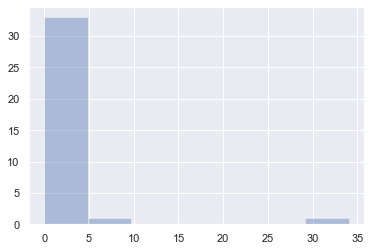

In [21]:
# Histogram of number of OutLinks per node, within ego-network
sns.distplot(outlinks_count, bins = len(index)//5, kde=False);

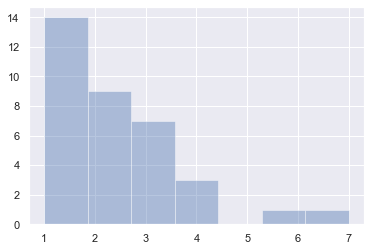

In [22]:
# Histogram of number of InLinks per node, within ego-network
sns.distplot(inlinks_count, bins = len(index)//5, kde=False);

## 2. Identify influential friends using 'Page Rank' formulation

From the adjacency matrix generated above, we can construct a column-stochastic matrix  (also called a transition matrix) such that, a column with `m` outlinks will have `1/m` as value in respective `m` cells. Conceptually, a value in the cell `a x b` gives the probability of a random-surfer in node B jumping to node A. 

In [23]:
binaryMap_cfr      = binaryMap_rfc.transpose()            # column-values: Outlinks
binaryMap_cfr_norm = binaryMap_cfr / binaryMap_cfr.sum(axis = 0)
colStochMatrix = np.matrix( binaryMap_cfr_norm.fillna(0)) # column-stochastic-matrix

In [31]:
binaryMap_cfr_norm

,555800349,368370629,936278616723283969,1083271068310167552,1077262370265882624,1041354301489143809,3273665052,550863197,711538784773349376,991172011383803905,...,802401256668962816,2987872843,552816252,2817090294,2770277582,293318078,2746233492,2714911410,2708920093,112417329
555800349,0.000000,NaN,0.000000,0.0,0.0,NaN,NaN,0.0,NaN,1.0,...,0.0,NaN,0.0,0.0,0.0,0.000000,0.0,NaN,NaN,NaN
368370629,0.029412,NaN,0.000000,0.0,0.0,NaN,NaN,0.0,NaN,0.0,...,0.0,NaN,0.0,0.0,0.0,0.000000,0.0,NaN,NaN,NaN
936278616723283969,0.029412,NaN,0.000000,0.0,0.0,NaN,NaN,0.0,NaN,0.0,...,0.0,NaN,0.0,0.0,0.0,0.000000,0.0,NaN,NaN,NaN
1083271068310167552,0.029412,NaN,0.000000,0.0,0.5,NaN,NaN,0.0,NaN,0.0,...,0.0,NaN,0.0,0.0,0.0,0.000000,0.0,NaN,NaN,NaN
1077262370265882624,0.029412,NaN,0.000000,1.0,0.0,NaN,NaN,0.0,NaN,0.0,...,0.0,NaN,0.0,0.0,0.0,0.000000,0.0,NaN,NaN,NaN
1041354301489143809,0.029412,NaN,0.000000,0.0,0.0,NaN,NaN,0.0,NaN,0.0,...,0.0,NaN,0.0,0.0,0.0,0.000000,0.0,NaN,NaN,NaN
3273665052,0.029412,NaN,0.000000,0.0,0.0,NaN,NaN,0.0,NaN,0.0,...,0.0,NaN,0.0,0.0,0.0,0.000000,0.0,NaN,NaN,NaN
550863197,0.029412,NaN,0.000000,0.0,0.0,NaN,NaN,0.0,NaN,0.0,...,0.0,NaN,0.0,0.0,0.0,0.000000,0.0,NaN,NaN,NaN
711538784773349376,0.029412,NaN,0.333333,0.0,0.0,NaN,NaN,0.0,NaN,0.0,...,0.0,NaN,0.0,0.0,0.0,0.000000,0.0,NaN,NaN,NaN
991172011383803905,0.029412,NaN,0.000000,0.0,0.0,NaN,NaN,0.0,NaN,0.0,...,0.0,NaN,0.0,0.0,0.0,0.000000,0.0,NaN,NaN,NaN


In [32]:
colStochMatrix

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.02941176, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.02941176, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.02941176, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.02941176, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.02941176, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

_Initialize PageRank vector, such that all the nodes have equal PageRank score adding upto 1._

In [33]:
pageRankVector = np.matrix([1.0/len(index)] *  len(index)) # iniitialize page-rank-vector 
pageRankVector = pageRankVector.transpose()                # transpose to column-vector

On applying the above Transition-matrix transformation iteratively on the PageRank vector, the vector will eventully converge such that:

`Matrix.Vector = Vector`

Equivalently, this is Eigen-Vector formulation with PageRank vector being the principal eigen-vector of matrix corresponding to eigen-value `1` [Since M is column-stochastic matrix, principal eigen-value is 1]

Here we use Power Iteration method to solve for the PageRank vector. Inorder to handle  the nodes which have zero out-links (dead-ends) and nodes with periodic-loops (spider-traps) in the ego-network, we introduce some randomness through parameter `beta` such that a random-surfer at any node picks a random path approx. every 1 out of 6 times ( 1 - beta = 0.15)

In [46]:
# PageRank algo: Power Iteration to solve Markov transition matrix 
# refer this     : http://setosa.io/blog/2014/07/26/markov-chains/index.html

beta = 0.85
epsilon = 999
iteration = 0
while epsilon > (1.0/(10**16)):
    pageRankVectorUpdating = colStochMatrix * pageRankVector * beta 
    
    # re-insert leaked page-ranks
    S = np.array(pageRankVectorUpdating).sum()                      
    pageRankVectorUpdated = pageRankVectorUpdating + (
        1 - S) * (1.0/len(index)) * np.ones_like(len(index))
    
    # compute the squared-difference and check for convergence
    error = np.array(pageRankVectorUpdated - pageRankVector)
    epsilon = np.sqrt((error *  error).sum())   
    iteration = iteration + 1
    pageRankVector = pageRankVectorUpdated    
    
print( "Sum of Page-Rank Scores: " + str(pageRankVector.sum()) + 
      "\nConverged in " + str(iteration) + " iterations")

Sum of Page-Rank Scores: 0.9999999999999998
Converged in 1 iterations


In [49]:
# Collect the results

results_df = pd.DataFrame()
results_df['Ids'], results_df['PageRank'] = index, pageRankVector
results_df['Inlinks'], results_df['Outlinks'] = list(inlinks_count), list(outlinks_count)
results_df = results_df.set_index('Ids', drop = True )

results_df = results_df.merge(lookup_in_cache(index), copy = False,
                              left_index = True, right_index = True)
results_df = results_df[['PageRank','UserName', 'FullName', 'Inlinks' , 'Outlinks',
                         'Followers','Friends', 'Location', 'Created' ]] 

... Cache-Miss for 35 nodes. Updating Cache...


In [50]:
results_df

,PageRank,UserName,FullName,Inlinks,Outlinks,Followers,Friends,Location,Created
Ids,,,,,,,,,
555800349,0.083054,RohanKuntoji,Rohan Kuntoji,7,34,34,71,"Mysore, India",2012-04-17
368370629,0.009679,MarutiTech,Maruti Techlabs,1,0,4079,4778,"Ahmadabad City, India",2011-09-05
936278616723283969,0.009679,NayakSowrabh21,Nayak Sowrabh,1,3,5,11,,2017-11-30
1083271068310167552,0.030108,lochana_abbur,Lochana Abbur,2,1,18,172,India,2019-01-10
1077262370265882624,0.048067,SubashApoorva,Apoorva Subash,3,2,13,96,Mysore,2018-12-24
1041354301489143809,0.009679,vishalpattanad,Vishalpattanad,1,0,4,124,,2018-09-16
3273665052,0.009679,yeshwanth_kt,Yeshwanth kt,1,0,3,10,"Mysore, India",2015-07-10
550863197,0.045171,Pai5566,Pai,3,1,74,618,India,2012-04-11
711538784773349376,0.017701,YashaswiniA5,Yashaswini A,3,0,5,106,,2016-03-20


In [25]:
results_df

,PageRank,UserName,FullName,Inlinks,Outlinks,Followers,Friends,Location,Created
Ids,,,,,,,,,
555800349,0.004957,RohanKuntoji,Rohan Kuntoji,7,71,34,71,"Mysore, India",Apr-2012
376825877,0.002929,TwitterOSS,Twitter Open Source,1,0,322729,50,Twitter HQ,Sep-2011
70831441,0.008212,soumithchintala,Soumith Chintala,6,2,70874,318,New York City,Sep-2009
2785337469,0.004203,seb_ruder,Sebastian Ruder,3,11,34573,751,"London, England",Sep-2014
1076526138736951298,0.004427,paperswithcode,Papers with Code,3,5,14671,44,"London, UK",Dec-2018
...,...,...,...,...,...,...,...,...,...
155659213,0.013575,Cristiano,Cristiano Ronaldo,8,0,80217624,51,"Turim, Piemonte",Jun-2010
113419517,0.021098,iHrithik,Hrithik Roshan,19,5,26437644,90,,Feb-2010
145125358,0.040777,SrBachchan,Amitabh Bachchan,23,32,38663364,1836,"Mumbai, India",May-2010


#### 2a. Nodes with high PageRank scores

In [51]:
results_df.fillna('').sort_values(by = 'PageRank', ascending =False).set_index('FullName').head(10)

,PageRank,UserName,Inlinks,Outlinks,Followers,Friends,Location,Created
FullName,,,,,,,,
AVINASH KEMPI,0.123444,AvinashKempi,6,5,155,596,BENGALURU,2014-11-07
Rohan Kuntoji,0.083054,RohanKuntoji,7,34,34,71,"Mysore, India",2012-04-17
Anup,0.072469,anupkale19,4,3,26,115,,2013-05-02
Saicharan,0.064230,09saicharan,4,2,17,119,,2016-11-26
Sandesh Bhat,0.051198,whaat_the_bhat,3,3,58,203,Depression,2015-12-26
Apoorva Subash,0.048067,SubashApoorva,3,2,13,96,Mysore,2018-12-24
suhas,0.046508,ShsuhasSuhas,3,3,110,535,Karnataka,2011-05-05
Pai,0.045171,Pai5566,3,1,74,618,India,2012-04-11
Andanur Chandan,0.044771,AndanurC,4,2,137,543,"Harihar, India",2014-08-19


In [52]:
results_df.FullName.unique()

array(['Rohan Kuntoji', 'Maruti Techlabs', 'Nayak Sowrabh',
       'Lochana Abbur', 'Apoorva Subash', 'Vishalpattanad',
       'Yeshwanth kt', 'Pai', 'Yashaswini A', 'Sohan Kuntoji',
       'Sandesh Bhat', 'Chinmay', 'G S Nandaraj',
       'Rakshak S | ರಕ್ಷಕ್ ಎಸ್', 'Soumak Chongder', 'Sumeet Kumar',
       'Sandesh Hegde', 'Vinod', 'AVINASH KEMPI', 'Ashika', 'Anup',
       'Vikas SM', 'Nikhil  P Huilgol', 'Pushpak C Gowda', 'Saicharan',
       'Abijeet Somani', 'Sanjay M', 'Nikhil Godi', 'Suhas', 'suhas',
       'Andanur Chandan', 'Akshay.S ', 'Abhijeet Somani',
       'Dr pandurangaiah R'], dtype=object)

#### 2b. Top 50 influential-nodes in Ego-Network

In [53]:
dummy_df = pd.DataFrame()
temp_df  = results_df.sort_values( by = 'PageRank', ascending =False)

for i in range(5):
    dummy_df[i] = pd.Series(list (temp_df [10*i : 10* i + 10]['FullName']))
dummy_df

,0,1,2,3,4
0,AVINASH KEMPI,Sanjay M,Soumak Chongder,Vikas SM,NaN
1,Rohan Kuntoji,Rakshak S | ರಕ್ಷಕ್ ಎಸ್,Abhijeet Somani,G S Nandaraj,NaN
2,Anup,Lochana Abbur,Akshay.S,Vinod,NaN
3,Saicharan,Sandesh Hegde,Nayak Sowrabh,Maruti Techlabs,NaN
4,Sandesh Bhat,Ashika,Vishalpattanad,Dr pandurangaiah R,NaN
5,Apoorva Subash,Sumeet Kumar,Suhas,NaN,NaN
6,suhas,Yashaswini A,Yeshwanth kt,NaN,NaN
7,Pai,Chinmay,Pushpak C Gowda,NaN,NaN
8,Andanur Chandan,Nikhil P Huilgol,Abijeet Somani,NaN,NaN
9,Nikhil Godi,Soumak Chongder,Sohan Kuntoji,NaN,NaN


#### 2c. Histogram of PageRank scores

PageRank scores are scaled such that nodes have an average-score of 1. So the scores below give an idea of how influential are the nodes, with respect to an average node. 

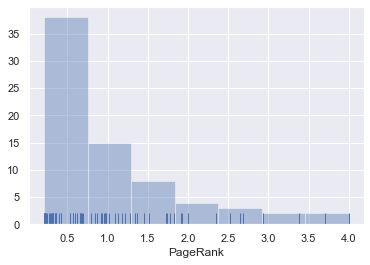

In [34]:
pageRank_to_plot = len(index) * results_df["PageRank"]
sns.distplot(pageRank_to_plot, kde=False, rug=True, bins = len(index)//10);

A joint-plot showing how Inlinks and Outlinks of the nodes are distributed (within the ego-network)

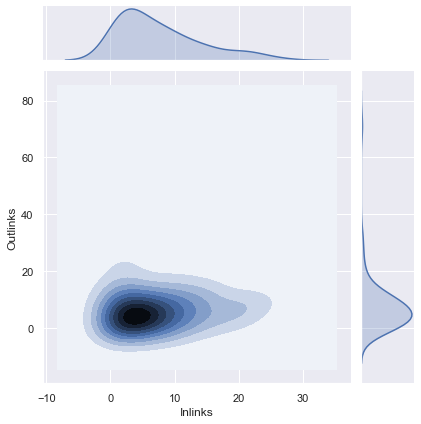

In [35]:
sns.jointplot(x="Inlinks", y="Outlinks", data=results_df, kind = "kde");

## 3. Identify implicit clusters using Clustering algos

Typically, number of clusters are chosen with a plot of within-cluster sum-of-squares-of-dstances vs number of clusters. 
Here for simplicity, we use a simple heuristic to fix the number of clusters in advnace.

In [37]:
n_clusters = min( int( round(np.sqrt(len(index)/2)) ), 10 ) # not more than 6 clusters
print(n_clusters)

6


## 3a. K-Means clustering

K Means is a point-assignment based clustering-algorithm: here we start with k points chosen randomly as centroids,  assign the remaining points to k centroids by using certain distance measure (Euclidean / Cosine / Jaccardi). Then we compute new centroids, re-assign remaining points and repeat, until there is convergence of centroids. 

Here we are more interested in clustering inherent in who-follows-me (network-driven) graph, rather than who-do-I-follow (self-driven). So the approach is to represent the nodes as Observations and whether other nodes follow them or not (1 or 0) as Features (One observation per row, and one feature per column) Thus the input matrix must be such that any value in cell implies whether node in the column follows node in the row.

In [38]:
from sklearn.cluster import KMeans
est = KMeans(max_iter = 100000, n_clusters = n_clusters, n_init = 200, init='k-means++')  
results_df['kmeans'] = est.fit_predict(binaryMap_cfr)

top_nodes_in_cluster(results_df.sort_values( by = 'PageRank', ascending =False), 
                     'kmeans', n_clusters)

,1 : 40 Ids,2 : 10 Ids,4 : 10 Ids
0,Tesla,Shah Rukh Khan,TensorFlow
1,Richard Branson,Hrithik Roshan,Google AI
2,Marques Brownlee,Leonardo DiCaprio,Andrew Ng
3,Cristiano Ronaldo,PRIYANKA,Ian Goodfellow
4,Harsha Bhogle,Aamir Khan,Kaggle
5,Tom Cruise,Farhan Akhtar,KDnuggets
6,UEFA Champions League,Anushka Sharma,Soumith Chintala
7,IndianPremierLeague,Deepika Padukone,Kirk Borne
8,President Trump,Sonam K Ahuja,Data Science Central
9,Indian Football Team,Alia Bhatt,Open Data Science


## 3b. Spectral clustering

One problem in using K-Means algorithm to cluster the given social-graph is 'Curse of Dimensionality' i.e. at higher-dimensions (here ~400 dimensions), metric like 'Euclidean distance' or 'Centre' would have little meaning in the context of non-convex adjacency matrix.

On the other hand, spectral clustering attempts to partition the graph such that number of edges which connect different components are minimized. Below is the output from Spectral Clustering.

In [39]:
from sklearn import cluster

spectral = cluster.SpectralClustering(n_clusters=n_clusters,  n_init = 500,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
spectral.fit(binaryMap_cfr)
results_df['spectral'] = spectral.labels_.astype(np.int)

top_nodes_in_cluster(results_df.sort_values( by = 'PageRank', ascending =False), 
                     'spectral', n_clusters)

/Users/kuntojirohan/MCG/Twitter/twitter_graph/py36/lib/python3.6/site-packages/sklearn/cluster/spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


,0 : 14 Ids,1 : 23 Ids,2 : 12 Ids
0,Mahendra Singh Dhoni,Google AI,TensorFlow
1,Marques Brownlee,Richard Branson,Andrew Ng
2,Cristiano Ronaldo,Tom Cruise,Ian Goodfellow
3,Harsha Bhogle,FC Barcelona,Kaggle
4,UEFA Champions League,Virgin,KDnuggets
5,IndianPremierLeague,Entrepreneur,Soumith Chintala
6,Indian Football Team,Rohan Kuntoji,Kirk Borne
7,Sunil Chhetri,Papers with Code,Data Science Central
8,Vir Das,IBM Data Science & AI,Open Data Science
9,ICC,Suhas Raju,Adam Geitgey


Nodes mainly into Deep Learning community have grouped into Cluster 8, Python Machine Learning community into Cluster 2, Design community into Cluster 9, general Data Science community into Cluster 0 and 5

One smaller clusters (1) wasn't shown above.

In [40]:
results_df [results_df['spectral'].isin([1])].sort_values(by = 'PageRank', ascending =False).set_index('FullName').head()

,PageRank,UserName,Inlinks,Outlinks,Followers,Friends,Location,Created,kmeans,spectral
FullName,,,,,,,,,,
Google AI,0.047022,GoogleAI,8,2,1380565,14,"Mountain View, CA",Apr-2009,4,1
Richard Branson,0.024579,richardbranson,6,7,12664546,3893,,Aug-2007,1,1
Tom Cruise,0.012091,TomCruise,3,9,6740721,53409,Worldwide,Jun-2009,1,1
FC Barcelona,0.009043,FCBarcelona,3,1,30930757,79,Barcelona,Dec-2009,1,1
Entrepreneur,0.005913,Entrepreneur,2,4,3463102,1454,"Irvine, CA",Jan-2009,1,1


## 3c. Affinity Propagation clustering

Unlike K-Means or Spectral clustering, affinity propagation doesn't require the number of clusters to be estimated beforehand. Here the algorithm finds 'exemplars' i.e. members of dataset that are representative of clusters. and tries to find clusters around them.  

In [41]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation(preference=-50).fit(binaryMap_cfr)
results_df['affinity'] = af.labels_
n_clusters_affinity = len(af.cluster_centers_indices_)

print(str(n_clusters_affinity) + " affinity clusters.")

top_nodes_in_cluster(results_df.sort_values( by = 'PageRank', ascending =False), 
                     'affinity', n_clusters_affinity)

2 affinity clusters.


,0 : 61 Ids,1 : 11 Ids
0,TensorFlow,Amitabh Bachchan
1,Google,Sachin Tendulkar
2,Google AI,Narendra Modi
3,Tesla,Virat Kohli
4,Elon Musk,Shah Rukh Khan
5,Bill Gates,Hrithik Roshan
6,Andrew Ng,Virender Sehwag
7,Richard Branson,PRIYANKA
8,Mahendra Singh Dhoni,Aamir Khan
9,Marques Brownlee,Farhan Akhtar


## 3d. Principal Component Analysis

To handle the 'curse of dimensionality' problem inherent in high-dimension data, PCA is generally used to represent the high-dimensional data in a fewer number of dimensions - this helps in better visualizing of data as well as faster computation while running clustering algorithm.

In [42]:
pca = PCA(n_components=3)
Xproj = pca.fit_transform(binaryMap_cfr)

results_df['dim1'] = Xproj[:,0]
results_df['dim2'] = Xproj[:,1]
results_df['dim3'] = Xproj[:,2]

results_df = results_df.sort_values( by = 'PageRank', ascending =False)
results_df.to_csv(cluster_filename)

print("Explained-variance and Proportion of Explained-variance in 3 dimensions [dim1 dim2 dim3]")
print(pca.explained_variance_, pca.explained_variance_ratio_)

Explained-variance and Proportion of Explained-variance in 3 dimensions [dim1 dim2 dim3]
[1.61749939 0.48646669 0.41671062] [0.2902709  0.08729965 0.07478146]


A simpler visualization of Spectral-clustering outcome as rendered in 2 dimensions.

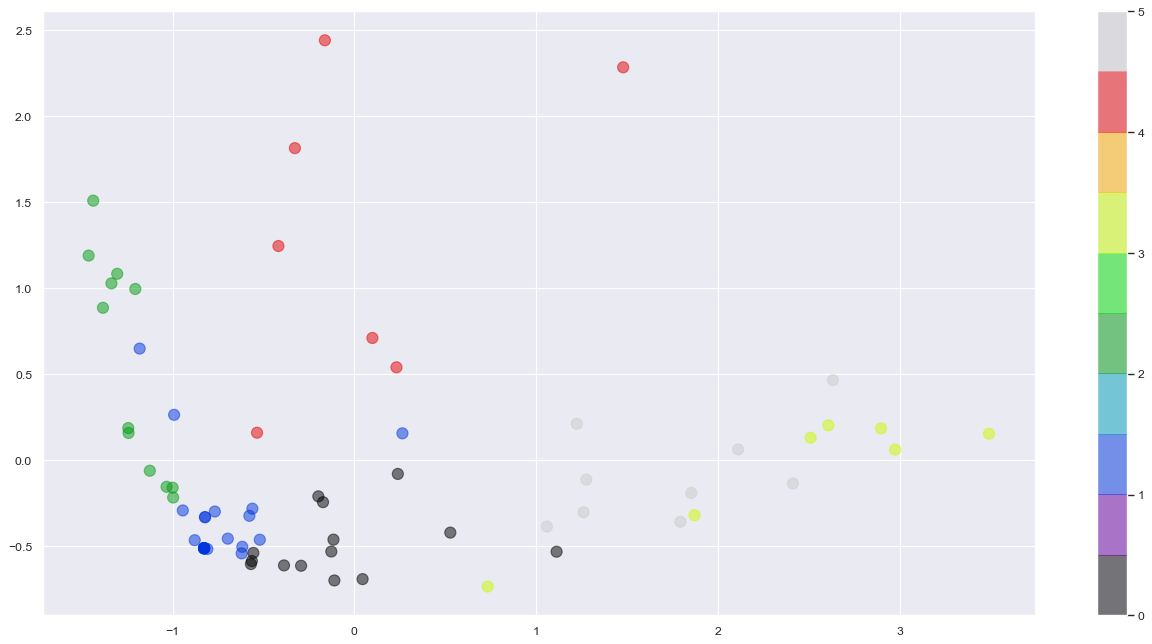

In [43]:
# Spectral clustering | Plot the ego-network in 2 dimensions

plt.figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(results_df['dim1'], results_df['dim2'], s = 100  ,c= results_df['spectral'], 
            alpha=0.5, cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar();

More on Clustering Algorithms:  http://scikit-learn.org/stable/modules/clustering.html

## 4. Recommend new friends to follow

Now that we have PageRank in place for nodes in social-graph, we can ask for recommendations on the basis of top-ranked nodes in the graph. E.g. To get 20 recommendations, after looking at friends of top PageRank scoring nodes in my network

#### 4a. Reco: After looking at top nodes in full ego-network

In [44]:
discover_Friends_toFollow(ids_of_interest = index,
                          friend_list = friends_of_self, 
                          prop = .5 , count =  20).fillna('').set_index('FullName')

'Who-To-Follow' reco after looking at  35 friends' friends:
... Cache-Miss for 20 nodes. Updating Cache...


,Freq,UserName,Followers,Friends,Location,Created
FullName,,,,,,
Yann LeCun,11,ylecun,157351,231,New York,Jun-2009
Andrej Karpathy,10,karpathy,231814,507,Stanford,Apr-2009
Andreas Mueller,9,amuellerml,35869,894,NYC,Jan-2012
DeepMind,9,DeepMindAI,258765,115,"London, UK",Jan-2016
Stanford NLP Group,9,stanfordnlp,81113,100,"Stanford, CA, USA",Feb-2010
François Chollet,9,fchollet,162588,595,"Mountain View, CA",Aug-2009
Fei-Fei Li,9,drfeifei,324869,264,"Stanford, CA, U.S.A.",Apr-2010
Hugo Larochelle,8,hugo_larochelle,72871,494,,Jun-2015
Jeff Dean,8,JeffDean,118243,2156,,Sep-2017


Recommendations on the basis of a specific cluster outcome. 
E.g. Nodes to follow on the basis of top PageRank nodes in 'Spectral Clustering::Data' clusters. 

#### Reco: 4b. After looking at Research (AI) community clustser (Spectral clustering)

In [77]:
favorite_cluster_df = results_df [results_df['spectral'].isin([2])]
favorite_cluster_list = list(favorite_cluster_df.index)

discover_Friends_toFollow(ids_of_interest = favorite_cluster_list, 
                          friend_list = friends_of_self, 
                          prop = .5, count = 30).fillna('').set_index('FullName')  

'Who-To-Follow' reco after looking at   6 friends' friends:


,Freq,UserName,Followers,Friends,Location,Created
FullName,,,,,,
Yann LeCun,6,ylecun,157351,231,New York,Jun-2009
Hugo Larochelle,5,hugo_larochelle,72871,494,,Jun-2015
Jeff Dean,5,JeffDean,118243,2156,,Sep-2017
Chris Olah,5,ch402,47210,172,"San Francisco, CA",Jun-2010
DeepMind,5,DeepMindAI,258765,115,"London, UK",Jan-2016
François Chollet,5,fchollet,162588,595,"Mountain View, CA",Aug-2009
Jeremy Howard,5,jeremyphoward,69888,1286,San Francisco,Aug-2010
Andrej Karpathy,5,karpathy,231814,507,Stanford,Apr-2009
Oriol Vinyals,4,OriolVinyalsML,77859,48,"London, England",Oct-2015


#### Reco: 4c. After looking at Bollywood actors clustser (Spectral clustering)

In [72]:
favorite_cluster_df = results_df [results_df['spectral'].isin([5])]
favorite_cluster_list = list(favorite_cluster_df.index)

discover_Friends_toFollow(ids_of_interest = favorite_cluster_list, 
                          friend_list = friends_of_self, 
                          prop = .5, count = 30).fillna('').set_index('FullName')  

'Who-To-Follow' reco after looking at   4 friends' friends:


,Freq,UserName,Followers,Friends,Location,Created
FullName,,,,,,
Chulbul Pandey,3,BeingSalmanKhan,38222008,24,MUMBAI,Apr-2010
Abhishek Bachchan,3,juniorbachchan,14707884,410,"Mumbai, India",Nov-2009
Karan Johar,3,karanjohar,16664147,485,"Maharashtra, India",Jul-2009
Barack Obama,3,BarackObama,108917081,611754,"Washington, DC",Mar-2007
Preity G Zinta,2,realpreityzinta,4806691,105,Catch me if you can....,Oct-2009
Dia Mirza,2,deespeak,3056203,1075,India,Feb-2010
Anil Kapoor,2,AnilKapoor,4994313,60,"Mumbai, India",Aug-2013
Ranveer Singh,2,RanveerOfficial,12789980,862,Mumbai,Aug-2009
Bubbles,2,bubblesbehl,7358,59,,Mar-2016


#### 4d.Reco:  After looking at Sports clustser (Spectral clustering)

In [73]:
favorite_cluster_df = results_df [results_df['spectral'].isin([0])]
favorite_cluster_list = list(favorite_cluster_df.index)

discover_Friends_toFollow(ids_of_interest = favorite_cluster_list, 
                          friend_list = friends_of_self, 
                          prop = .5, count = 30).fillna('').set_index('FullName')

'Who-To-Follow' reco after looking at   7 friends' friends:


,Freq,UserName,Followers,Friends,Location,Created
FullName,,,,,,
Ashwin Ravichandran,3,ashwinravi99,9698651,236,Chennai,Aug-2011
Gautam Gambhir,3,GautamGambhir,9938638,121,,Dec-2009
Suresh Raina🇮🇳,3,ImRaina,16857878,300,India,Mar-2010
Twitter Sports,3,TwitterSports,15272596,1992,,May-2011
Ishant Sharma,2,ImIshant,2264007,60,"New Delhi, India",Dec-2009
Rohit Sharma,2,ImRo45,14930299,43,,Mar-2010
R P Singh रुद्र प्रताप सिंह,2,rpsingh,1574542,322,"Rae bareli, India",Feb-2010
Amit Mishra,2,MishiAmit,1354021,54,Delhi,Apr-2010
Prannoy Roy,2,PrannoyRoyNDTV,758697,487,India,Oct-2009


#### Reco: 4e. After looking at Tech & Media community clustser (Spectral clustering)

In [86]:
favorite_cluster_df = results_df [results_df['spectral'].isin([4])]
favorite_cluster_list = list(favorite_cluster_df.index)

discover_Friends_toFollow(ids_of_interest = favorite_cluster_list, 
                          friend_list = friends_of_self, 
                          prop = .5, count = 30).fillna('').set_index('FullName')  

'Who-To-Follow' reco after looking at   3 friends' friends:


,Freq,UserName,Followers,Friends,Location,Created
FullName,,,,,,
New Scientist,3,newscientist,3528447,145,Worldwide,Jan-2009
Slashdot,2,slashdot,241209,147,San Francisco,Mar-2007
Ars Technica,2,arstechnica,1168522,1233,NYC - Boston - Chicago - SF,Jan-2007
GigaOm,2,gigaom,309985,1155,"Austin, TX",Mar-2007
Gizmodo,2,Gizmodo,2892136,139,,Mar-2007
TechCrunch,2,TechCrunch,10104486,1050,"San Francisco, CA",Mar-2007
NASA,2,NASA,33248641,298,,Dec-2007
Techmeme,2,Techmeme,399577,921,United States,Mar-2007
The Onion,2,TheOnion,11320535,15,,Mar-2008


In [92]:
discover_Friends_toFollow(ids_of_interest = list(results_df [results_df['spectral'] == 5].index), 
                          friend_list = friends_of_self, 
                          prop = 1, count = 20).fillna('').set_index('FullName')  

'Who-To-Follow' reco after looking at   9 friends' friends:
... Cache-Miss for 4 nodes. Updating Cache...


,Freq,UserName,Followers,Friends,Location,Created
FullName,,,,,,
Karan Johar,8,karanjohar,16664147,485,"Maharashtra, India",Jul-2009
Ranveer Singh,7,RanveerOfficial,12789980,862,Mumbai,Aug-2009
Shahid Kapoor,7,shahidkapoor,14494052,96,,Jul-2009
Abhishek Bachchan,7,juniorbachchan,14707884,410,"Mumbai, India",Nov-2009
Chulbul Pandey,6,BeingSalmanKhan,38222008,24,MUMBAI,Apr-2010
Barack Obama,6,BarackObama,108917081,611754,"Washington, DC",Mar-2007
taran adarsh,6,taran_adarsh,3680564,179,"Mumbai, India",Dec-2009
Arjun Kapoor,6,arjunk26,6128252,794,,Apr-2014
J,6,jiteshpillaai,721109,1170,Mumbai,May-2009
